In [15]:
import random
import time
import pynq
from pynq import Overlay
import numpy as np
from pynq import Clocks
from pynq import allocate
import sys
import struct
import matplotlib.pyplot as plt

def LDL_dsolve(n, X, D, Xout_sw):
    for i in range(n):
        Xout_sw[i] = X[i] / D[i]

def generate_random_array(n, min_value, max_value):
    return [random.uniform(min_value, max_value) for _ in range(n)]

def round_array(arr, decimals):
    return [round(num, decimals) for num in arr]

def measure_execution_time(func, *args):
    start_time = time.time()
    func(*args)
    end_time = time.time()
    return end_time - start_time

In [16]:
alveare = Overlay("./bitstream/doublerate.bit")
ape = alveare.ldl_dsolve_0

n = 10, Software Time = 2.2077560424804686e-05, Hardware Time = 0.00014009475708007813
n = 100, Software Time = 7.405281066894532e-05, Hardware Time = 9.679794311523438e-05
n = 1000, Software Time = 0.0007776737213134766, Hardware Time = 0.0001346111297607422
n = 10000, Software Time = 0.008556509017944336, Hardware Time = 0.0007899284362792968
n = 100000, Software Time = 0.08917150497436524, Hardware Time = 0.0013358116149902344
n = 1000000, Software Time = 0.8928386688232421, Hardware Time = 0.008256053924560547


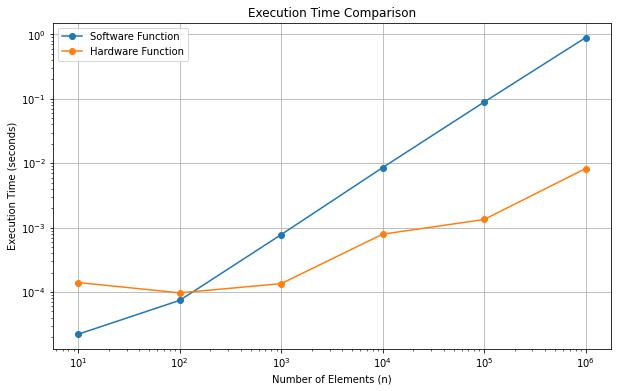

In [17]:
# Provided n_values and other parameters
n_values = [10, 100, 1000, 10000, 100000, 1000000]
k = 500
runs = 5

times_sw = []
times_hw = []

for j in n_values:
    time_sw = 0.0
    time_hw = 0.0
    for _ in range(runs):
        X = generate_random_array(j, 0.1, k)
        X = round_array(X, 7)
        D = generate_random_array(j, 0.1, k)
        D = round_array(D, 7)
        Xout_sw = [0.0] * j
        Xout_hw = [0.0] * j
        
        X_hw = pynq.allocate(j, np.float64)
        D_hw = pynq.allocate(j, np.float64)
        Xout_hw = pynq.allocate(j, np.uint64)
        
        X_hw[:] = X
        D_hw[:] = D
        
        ape.register_map

        ape.write(0x18, X_hw.physical_address)
        ape.write(0x24, D_hw.physical_address)
        ape.write(0x30, Xout_hw.physical_address)
        ape.write(0x10, j)
        
        time_sw += measure_execution_time(LDL_dsolve, j, X, D, Xout_sw)
        
        start_time_hw = time.time()
        # start
        ape.write(0x00, 0x01)
        # polling
        while ape.read(0x00) & 0x4 != 4:
            pass
        # read back
        Xout_hw.sync_from_device()
        end_time_hw = time.time()
        time_hw += end_time_hw - start_time_hw
        
    avg_time_sw = time_sw / runs
    avg_time_hw = time_hw / runs
    
    times_sw.append(avg_time_sw)
    times_hw.append(avg_time_hw)
    
    # Print the coordinates
    print(f"n = {j}, Software Time = {avg_time_sw}, Hardware Time = {avg_time_hw}")

plt.figure(figsize=(10, 6))
plt.plot(n_values, times_sw, label='Software Function', marker='o')
plt.plot(n_values, times_hw, label='Hardware Function', marker='o')
plt.xlabel('Number of Elements (n)')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()